### Tensorflow data pipeline
The point of this notebook is to demonstrate how tf.data pipeline can increase the speed compare to Keras ImageDataGenerator.<br>
Using tf.data I was able to increase GPU usage from 15-20% to 40-45% and reduce training time by approximately **3 times !**

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import RandomTranslation, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import SGD

from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import to_categorical

from numpy.random import seed
from tensorflow.random import set_seed


#### Set size and random state

In [2]:
SIZE = 28
SEED = 17

set_seed(SEED)
seed(SEED)

### Data loading

In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv').to_numpy()
test = pd.read_csv('../input/digit-recognizer/test.csv').to_numpy()
print(train.shape, test.shape)

(42000, 785) (28000, 784)


### Data processing
As you can see I'm doing all 'static' operations (rescale, reshape, etc.) in advance. I could apply the scaling later  during augmentation using the GPU, but this approach allows me to use the GPU resources exclusively for training

In [4]:
train_Y = to_categorical(train[:,0])

train_X = train[:,1:] / 255.0
test_X = test / 255.0

train_X = train_X.reshape(-1, SIZE, SIZE, 1)
test_X = test_X.reshape(-1, SIZE, SIZE, 1)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size = 0.2,
                                                     stratify = train_Y, random_state = SEED)

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape, test_X.shape)

(33600, 28, 28, 1) (33600, 10) (8400, 28, 28, 1) (8400, 10) (28000, 28, 28, 1)


#### Set constants

In [5]:
BS = 64
EPOCHS = 50

STEPS = len(train_X) // BS
LABELS = 10

#### Build TensorFlow input pipelines

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_X, valid_Y))

train_ds = train_ds.shuffle(STEPS * BS).batch(BS).repeat().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BS)

2022-03-24 08:51:56.669200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 08:51:56.754868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 08:51:56.755672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 08:51:56.759364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

#### Model

All 'dynamic' transformation are applying inside of the model. Plase note, that these layers are only active for *fit* calls, but not for *evaluate* or *predict*

In [7]:
class Model:
    @staticmethod
    def build(height, width, depth):
        model = keras.Sequential()
        
        #Input
        model.add(Input((height, width, depth)))

        #Augmentation layers (applying only call to model.fit)
        model.add(RandomTranslation(0.05,0.05,seed=SEED)) 
        model.add(RandomZoom(0.01, 0.01, seed=SEED))
        model.add(RandomRotation(0.125, seed=SEED)) 
        
        #CNN layers
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Flatten())
        
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(10, activation = 'softmax'))
        
        return model

#### Build and compile model

In [8]:
model = Model.build(SIZE, SIZE, 1)
model.summary()

optimizer = SGD(learning_rate = 5e-4)

early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 1e-3,
    restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

LR = LearningRateScheduler(scheduler)

model.compile(
    optimizer = 'SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    steps_per_execution = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_translation (RandomTr (None, 28, 28, 1)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 28, 28, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        2

#### Fit model

In [9]:
%%time
H = model.fit(
train_ds, validation_data = valid_ds,
epochs=EPOCHS,
steps_per_epoch = STEPS,
callbacks = [early_stopping, LR])

Epoch 1/50


2022-03-24 08:52:00.896596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-24 08:52:01.916527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


525/525 [==============================] - 13s 10ms/step - loss: 0.3888 - accuracy: 0.8930 - val_loss: 0.2131 - val_accuracy: 0.9670
Epoch 2/50
525/525 [==============================] - 4s 8ms/step - loss: 0.1425 - accuracy: 0.9592 - val_loss: 0.0817 - val_accuracy: 0.9744
Epoch 3/50
525/525 [==============================] - 5s 9ms/step - loss: 0.1066 - accuracy: 0.9698 - val_loss: 0.0651 - val_accuracy: 0.9802
Epoch 4/50
525/525 [==============================] - 4s 8ms/step - loss: 0.0899 - accuracy: 0.9734 - val_loss: 0.0583 - val_accuracy: 0.9815
Epoch 5/50
525/525 [==============================] - 4s 8ms/step - loss: 0.0785 - accuracy: 0.9766 - val_loss: 0.0579 - val_accuracy: 0.9821
Epoch 6/50
525/525 [==============================] - 4s 8ms/step - loss: 0.0716 - accuracy: 0.9786 - val_loss: 0.0518 - val_accuracy: 0.9833
Epoch 7/50
525/525 [==============================] - 4s 8ms/step - loss: 0.0659 - accuracy: 0.9807 - val_loss: 0.0446 - val_accuracy: 0.9868
Epoch 8/50
525/

#### Metrics

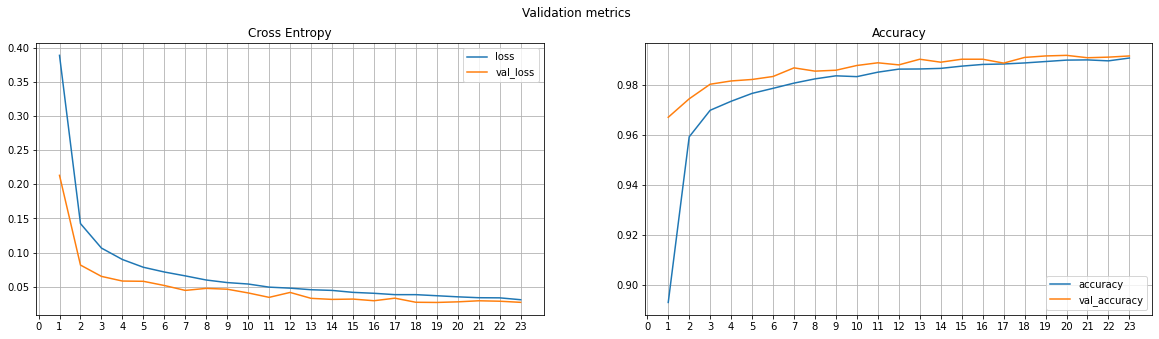

In [10]:
df = pd.DataFrame(H.history)
df.index += 1
fig = plt.figure(figsize = (20,5))
fig.suptitle('Validation metrics')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks(range(len(df)+1))
ax2.set_xticks(range(len(df)+1))
df[['loss', 'val_loss']].plot(title="Cross Entropy", grid=True, ax=ax1)
df[['accuracy', 'val_accuracy']].plot(title="Accuracy",grid=True, ax=ax2)
plt.show()

#### Model serialization

In [11]:
model.save('model.h5', save_format='h5')

#### Predictions

In [12]:
pred = model.predict(test_X)
classes = pred.argmax(axis=-1)

sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.Label = classes
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


 #### Submission

In [13]:
sub.to_csv('submission.csv', index = False)

CNN part of the model was taken from [**KASSEM Notebook**](https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook)